In [85]:
import numpy as np
import matplotlib.pyplot as plt

In [89]:
def projection_2d(nx, ny, lx, ly, Re):
    dx = lx / (nx - 1)
    dy = ly / (ny - 1)
    miu= 1/Re
    nt = 500
    dt = 0.01
    rho = 1.0
    u = np.ones((ny, nx))
    v = np.zeros((ny, nx))
    u_star = np.zeros((ny, nx))
    v_star = np.zeros((ny, nx))
    p = np.zeros((ny, nx))
    u_new = np.zeros((ny, nx))
    v_new = np.zeros((ny, nx))
    error_limit = 1e-6

    u, v, p = initial_condition(u, v, p)
    
    for n in range(nt):
        for j in range(1,ny-1):
            for i in range(1,nx-1):
                if u[i,j] > 0:
                    u_x_part = u[j,i] - u[j,i-1]
                    v_x_part = v[j,i] - v[j,i-1]
                else:
                    u_x_part = u[j,i+1] - u[j,i]
                    v_x_part = v[j,i+1] - v[j,i]                    
                if v[i,j] > 0:
                    u_y_part = u[j,i] - u[j-1,i]
                    v_y_part = v[j,i] - v[j-1,i]
                else:
                    u_y_part = u[j+1,i] - u[j,i]
                    v_y_part = v[j+1,i] - v[j,i]

                u_star[j,i] = ( miu * ( dt*(u[j,i+1]-2*u[j,i]+u[j,i-1])/dx**2 + dt*(u[j+1,i]-2*u[j,i]+u[j-1,i])/dy**2 ) 
                        - u[j,i]*dt*(u_x_part)/(dx) - v[j,i]*dt*(u_y_part)/(dy) )/2 + u[j,i]
                
                v_star[j,i] = ( miu * ( dt*(v[j,i+1]-2*v[j,i]+v[j,i-1])/dx**2 + dt*(v[j+1,i]-2*v[j,i]+v[j-1,i])/dy**2 ) 
                        - u[j,i]*dt*(v_x_part)/(dx) - v[j,i]*dt*(v_y_part)/(dy) )/2 + v[j,i]
    
        # boundary conditions
        u_star, v_star = boundary_condition(u_star, v_star)
    
        # pressure equation
        A = np.zeros((nx * ny, nx * ny))
        b = np.zeros(nx * ny)
    
        for j in range(ny):
            for i in range(nx):
                k = j * nx + i
                if i == 0 or i == nx - 1:
                    A[k, k] = 1
                    b[k] = p[j, i]
                elif j == 0:
                    A[k, k] = 1
                    A[k, k + nx] = -1
                    b[k] = 0
                elif j == ny - 1:
                    A[k, k] = 1
                    A[k, k - nx] = -1
                    b[k] = 0
                else:
                    A[k, k] = -2 * (dx ** 2 + dy ** 2)
                    A[k, k - 1] = dy ** 2
                    A[k, k + 1] = dy ** 2
                    A[k, k - nx] = dx ** 2
                    A[k, k + nx] = dx ** 2
                    b[k] = 2 * (dx**2 * dy**2) * ( rho*(u_star[j,i+1]-u_star[j,i-1])/(2*dx) + rho*(v_star[j+1,i]-v_star[j-1,i])/(2*dy) ) / dt           
                    
        p_new = np.linalg.solve(A, b)
        p_new = p_new.reshape(ny, nx)       
              
        # next u and v    
        for j in range(1,ny-1):
            for i in range(1,nx-1):
                u_new[j,i] = u_star[j,i] - (0.25*dt/dx)*(p_new[j,i+1]-p_new[j,i-1])
                v_new[j,i] = v_star[j,i] - (0.25*dt/dy)*(p_new[j+1,i]-p_new[j-1,i])
        
        # boundary conditions
        u_new, v_new = boundary_condition(u_new, v_new)
        
        # error
        u_diff_norm = np.linalg.norm(u_new - u)
        v_diff_norm = np.linalg.norm(v_new - v)
        u_norm = np.linalg.norm(u)
        v_norm = np.linalg.norm(v)

        error_u = u_diff_norm / u_norm if u_norm != 0 else u_diff_norm
        error_v = v_diff_norm / v_norm if v_norm != 0 else v_diff_norm

        if error_u < error_limit and error_v < error_limit:
            u[:, :] = u_new[:, :]
            v[:, :] = v_new[:, :]
            print(n)
            break
        u[:, :] = u_new[:, :]
        v[:, :] = v_new[:, :]
    
    return u_new, p_new

def boundary_condition(u,v):
    u[0, :] = 0
    u[-1, :] = 0
    u[:, 0] = u[:, 1]
    u[:, -1] = u[:, -2]

    v[0, :] = 0
    v[-1, :] = 0
    v[:, 0] = v[:, 1]
    v[:, -1] = v[:, -2]

    return u, v

def initial_condition(u, v, p):
    u = u
    v = v
    p[:, 0] = 5.0
    p[:, -1] = 0.0

    return u, v, p

def analytical_solution(nx_a, ny_a, p_high, p_low, mio, lx_a, ly_a):
    h = ly_a / 2
    x_a = np.linspace(0, lx_a, nx_a)
    y_a = np.linspace(0, ly_a, ny_a)
    u_a = np.zeros((ny_a, nx_a))
    p_a = np.zeros((ny_a, nx_a))
    
    for j in range(ny_a):
        for i in range(nx_a):
            u_a[j, i] = ((p_high - p_low) / (2 * mio * lx_a)) * (h ** 2 - (y_a[j] - h) ** 2)
            p_a[j, i] = p_high - (p_high - p_low) * x_a[i] / lx_a
            
    return u_a, p_a

def compute_error(u_numerical, u_analytical, p_numerical, p_analytical):
    u_error = np.sum(abs(u_numerical - u_analytical)) / np.size(u_numerical) 
    p_error = np.sum(abs(p_numerical - p_analytical)) / np.size(p_numerical) 
    
    return u_error, p_error 

def compute_order(errors, grid_resolutions):
    order=[]

    for i in range(len(errors)-1):
        a = abs(np.log(errors[i])-np.log(errors[-1]))/abs(np.log(grid_resolutions[i])-np.log(grid_resolutions[-1]))
        order.append(a)

    return order


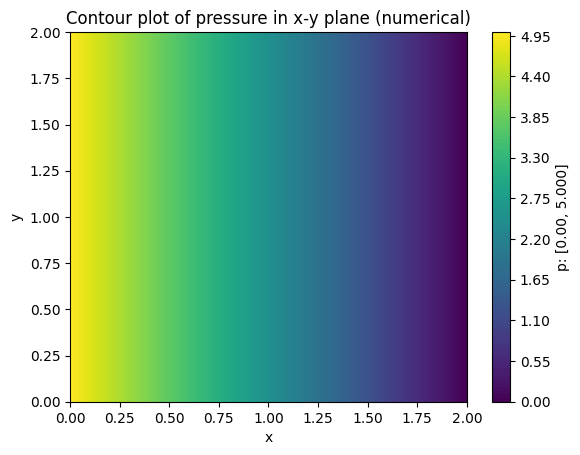

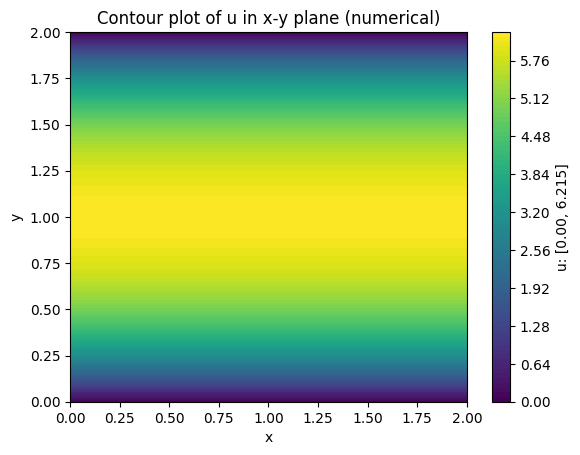

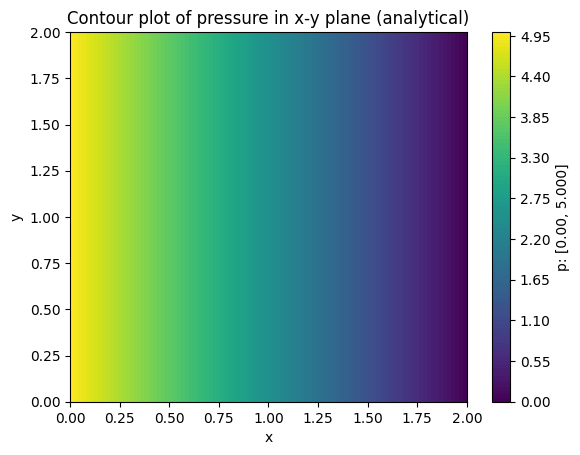

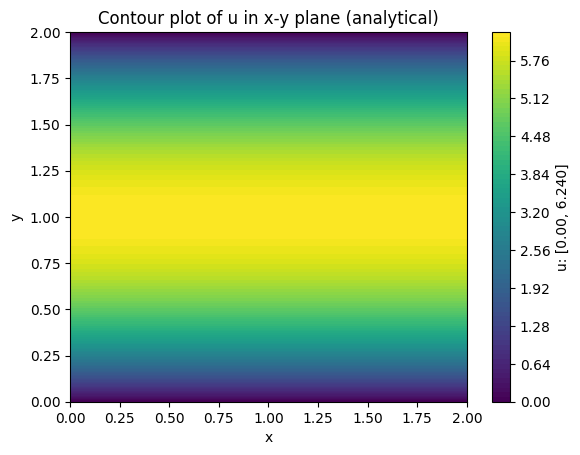

In [100]:
# grid_resolutions = [5, 6, 7, 8, 9, 10, 11, 13, 15, 17, 21]
grid_resolutions = [6, 7, 8, 9, 10, 11, 13, 15, 17, 21, 23, 26]
lx = 2
ly = 2
Re = 10
miu = lx/(Re)
u_errors = []
p_errors = []


for res in grid_resolutions:
    u_numerical, p_numerical = projection_2d(res, res, lx, ly, Re)    
    u_analytical, p_analytical = analytical_solution(res, res, 5.0, 0.0, miu, lx, ly)
    u_error, p_error = compute_error(u_numerical, u_analytical, p_numerical, p_analytical)
    u_errors.append(u_error)
    p_errors.append(p_error)
    if res == grid_resolutions[-1]:
        x_a = np.linspace(0, lx, res)
        y_a = np.linspace(0, ly, res)
        X, Y = np.meshgrid(x_a, y_a)

        #plot the u and p in the last grid resolution
        plt.figure()
        plt.contourf(X, Y, p_numerical, levels=100)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Contour plot of pressure in x-y plane (numerical)')
        plt.colorbar(format='%.2f', label='p: [{:.2f}, {:.3f}]'.format(np.min(p_numerical), np.max(p_numerical)))
        plt.show()
        
        plt.figure()
        plt.contourf(X, Y, u_numerical, levels=100)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Contour plot of u in x-y plane (numerical)')
        plt.colorbar(format='%.2f', label='u: [{:.2f}, {:.3f}]'.format(np.min(u_numerical), np.max(u_numerical)))
        plt.show()

        plt.figure()
        plt.contourf(X, Y, p_analytical, levels=100)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Contour plot of pressure in x-y plane (analytical)')
        plt.colorbar(format='%.2f', label='p: [{:.2f}, {:.3f}]'.format(np.min(p_analytical), np.max(p_analytical)))
        plt.show()
        
        plt.figure()
        plt.contourf(X, Y, u_analytical, levels=100)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Contour plot of u in x-y plane (analytical)')
        plt.colorbar(format='%.2f', label='u: [{:.2f}, {:.3f}]'.format(np.min(u_analytical), np.max(u_analytical)))
        plt.show()


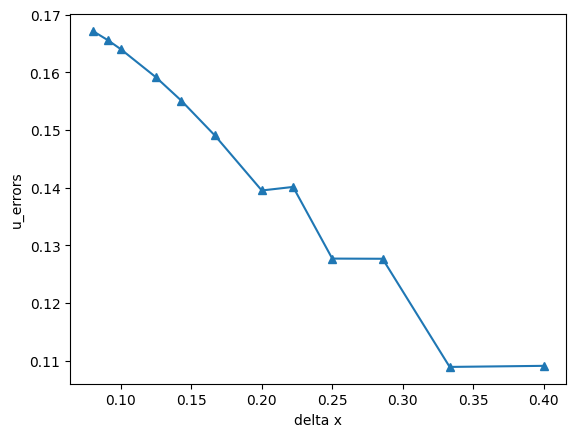

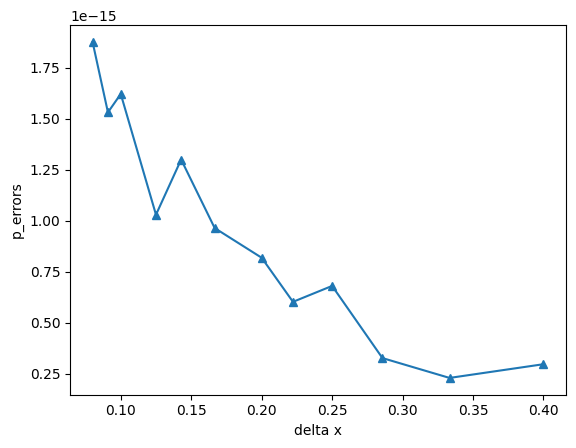

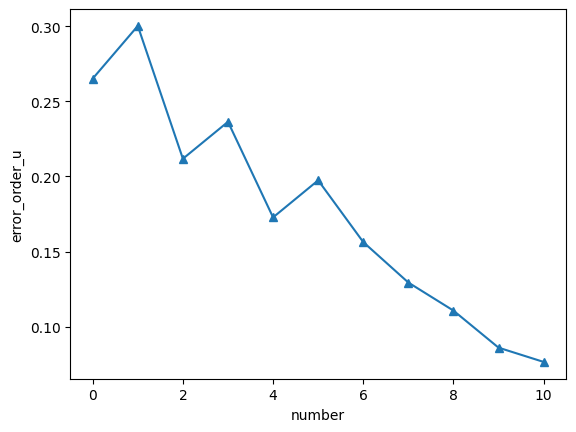

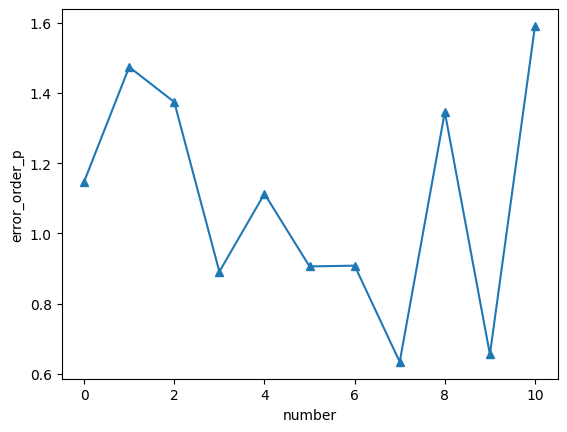

In [101]:
h = lx/(np.array(grid_resolutions)-1)

error_order_u = compute_order(u_errors,h)
error_order_p = compute_order(p_errors,h)


# Plot error
plt.plot(h, u_errors, marker='^')
plt.xlabel('delta x')
plt.ylabel('u_errors')
plt.show()

plt.plot(h, p_errors, marker='^')
plt.xlabel('delta x')
plt.ylabel('p_errors')
plt.show()

#plot error order
plt.plot(error_order_u, marker='^')
plt.xlabel('number')
plt.ylabel('error_order_u')
plt.show()

plt.plot(error_order_p, marker='^')
plt.xlabel('number')
plt.ylabel('error_order_p')
plt.show()